In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np

In [2]:
uri = "bolt://34.101.192.24:7687"
username = "neo4j"
password = "unej1234"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [23]:
def extract_node_properties_and_relationships():
    with driver.session() as session:
        # Cypher query to fetch node properties and relationships
        query = """
        MATCH (n)-[r]->(m)
            WHERE any(label IN labels(n) WHERE label IN ['Gejala', 'PenyakitPadi', 'HamaPadi']) 
            AND any(label IN labels(m) WHERE label IN ['Gejala', 'PenyakitPadi', 'HamaPadi'])
        RETURN 
        m.Vector AS source_vector, m.label AS source_label, labels(m) AS source_class, 
        type(r) AS relationship_type,
        n.Vector AS target_vector, n.label AS target_label, labels(n) AS target_class

        """
        result = session.run(query)
        # Extract properties and relationships and store in DataFrame
        df = pd.DataFrame([record.values() for record in result], columns=result.keys())
        # Clean labels
        df['source_class'] = df['source_class'].apply(lambda entry: [item for item in entry if item not in ["Resource", "NamedIndividual"]])
        df['target_class'] = df['target_class'].apply(lambda entry: [item for item in entry if item not in ["Resource", "NamedIndividual"]])
        return df

# Call the function to extract node properties and relationships
Rice_KG_df = extract_node_properties_and_relationships()

# Print the DataFrame
Rice_KG_df

,source_vector,source_label,source_class,relationship_type,target_vector,target_label,target_class
0,"[0.03818255290389061, -0.015258912928402424, -...",Bulir terdapat bercak,[Gejala],memilikiGejala,"[0.03452454134821892, 0.04011273384094238, -0....",Gosong bulir,[PenyakitPadi]
1,"[0.03753756731748581, 0.005460740067064762, -0...",Bulir pecah,[Gejala],memilikiGejala,"[0.03452454134821892, 0.04011273384094238, -0....",Gosong bulir,[PenyakitPadi]
2,"[0.03612148016691208, 0.0048484764993190765, 0...",Bulir berubah warna,[Gejala],memilikiGejala,"[0.03452454134821892, 0.04011273384094238, -0....",Gosong bulir,[PenyakitPadi]
3,"[0.03656195476651192, 0.02377898246049881, 0.0...",Bulir mengalami kerusakan,[Gejala],memilikiGejala,"[0.03452454134821892, 0.04011273384094238, -0....",Gosong bulir,[PenyakitPadi]
4,"[0.038021307438611984, -0.010079000145196915, ...",Malai terdapat bercak,[Gejala],memilikiGejala,"[0.03643496334552765, -0.020186755806207657, -...",Garis Merah,[PenyakitPadi]
...,...,...,...,...,...,...,...
131,"[0.038021307438611984, -0.010079000145196915, ...",Malai terdapat bercak,[Gejala],memilikiGejala,"[0.03919482231140137, -0.031110592186450958, 0...",Penggerek Batang Kuning,[HamaPadi]
132,"[0.033894460648298264, -0.014245453290641308, ...",Daun terdapat bercak,[Gejala],memilikiGejala,"[0.03919482231140137, -0.031110592186450958, 0...",Penggerek Batang Kuning,[HamaPadi]
133,"[0.03758235648274422, 0.02068854123353958, 0.0...",Batang rapuh,[Gejala],memilikiGejala,"[0.03914107382297516, -0.029383953660726547, -...",Rayap,[HamaPadi]
134,"[0.03786005824804306, -0.004899086430668831, 0...",Akar berlubang,[Gejala],memilikiGejala,"[0.03914107382297516, -0.029383953660726547, -...",Rayap,[HamaPadi]


In [41]:
synthetic_data = pd.concat([Rice_KG_df] * 100, ignore_index=True)  # Adjust the multiplier (2 in this case) as needed

In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the categorical variables
label_encoder_source = LabelEncoder()

label_encoder_relationship = LabelEncoder()
label_encoder_target = LabelEncoder()

synthetic_data['source_label_encoded'] = label_encoder_source.fit_transform(synthetic_data['source_label'])
synthetic_data['relationship_type_encoded'] = label_encoder_relationship.fit_transform(synthetic_data['relationship_type'])
synthetic_data['target_label_encoded'] = label_encoder_target.fit_transform(synthetic_data['target_label'])

# Define the feature matrix and target vector
X = synthetic_data[['source_label_encoded', 'relationship_type_encoded']]
y = synthetic_data['target_label_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder_target.classes_)

# Calculate feature importances
feature_importances = clf.feature_importances_

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Feature Importances: {feature_importances}')

Accuracy: 0.35024509803921566
Classification Report:
                           precision    recall  f1-score   support

                  Bakanae       0.63      0.61      0.62       186
       Bakteri Garis Daun       0.00      0.00      0.00       188
           Belalang Sawah       0.70      0.59      0.64       131
     Belatung Lalat Bibit       0.00      0.00      0.00        97
            Bercak Coklat       0.48      0.21      0.29       144
                     Blas       1.00      0.30      0.46       127
Bulir mengalami kerusakan       0.00      0.00      0.00        28
               Busuk Akar       0.49      0.79      0.61       150
             Busuk Batang       0.53      0.74      0.62       110
            Busuk Pelepah       1.00      0.78      0.88       126
         Ganjur Padi Asia       0.00      0.00      0.00        70
              Garis Merah       0.00      0.00      0.00       122
             Gosong bulir       0.59      1.00      0.75       126
      Ha

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder_target.classes_)

# Calculate feature importances
feature_importances = clf.feature_importances_

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Feature Importances: {feature_importances}')

Accuracy: 0.35024509803921566
Classification Report:
                           precision    recall  f1-score   support

                  Bakanae       0.63      0.61      0.62       186
       Bakteri Garis Daun       0.00      0.00      0.00       188
           Belalang Sawah       0.70      0.59      0.64       131
     Belatung Lalat Bibit       0.00      0.00      0.00        97
            Bercak Coklat       0.27      0.38      0.31       144
                     Blas       1.00      0.30      0.46       127
Bulir mengalami kerusakan       0.00      0.00      0.00        28
               Busuk Akar       0.49      0.79      0.61       150
             Busuk Batang       0.53      0.74      0.62       110
            Busuk Pelepah       1.00      0.78      0.88       126
         Ganjur Padi Asia       0.00      0.00      0.00        70
              Garis Merah       0.09      0.20      0.13       122
             Gosong bulir       0.59      1.00      0.75       126
      Ha

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Neural Network

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Concatenate source and target vectors as features
X = np.concatenate([Rice_KG_df['source_vector'].values.tolist(), Rice_KG_df['target_vector'].values.tolist()], axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Rice_KG_df['relationship_type'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax') # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Evaluate the model
loss, nn_accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", nn_accuracy)


Epoch 1/100


c:\Users\Ariful\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - accuracy: 0.4070 - loss: 1.7730   
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - loss: 1.7127 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9432 - loss: 1.6337  
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9118 - loss: 1.5460 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9505 - loss: 1.4103  
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9190 - loss: 1.2702
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9152 - loss: 1.0930  
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.9113 - loss: 0.8860
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9307 - loss: 0.6638  
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.9246 - loss: 0.5328
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9307 - loss: 0.4115 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.9035 - loss: 0.4

In [ ]:
#CNN

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

# Reshape the input data to be suitable for a 1D CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Evaluate the model
loss, cnn_accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", cnn_accuracy)


Epoch 1/100


c:\Users\Ariful\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5620 - loss: 1.7810      
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9316 - loss: 1.6881 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9100 - loss: 1.5011 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9015 - loss: 1.1398 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9243 - loss: 0.6345  
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.9375 - loss: 0.3588
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9389 - loss: 0.3709 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9202 - loss: 0.3903 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.3128 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9276 - loss: 0.4166 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9312 - loss: 0.3465  
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9194 - loss: 0.39

In [ ]:
#RNN

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

# Function to safely evaluate a string representation of a list
def safe_eval(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

# Apply the safe_eval function to convert vector columns from string to list (if necessary)
Rice_KG_df['source_vector'] = Rice_KG_df['source_vector'].apply(safe_eval)
Rice_KG_df['target_vector'] = Rice_KG_df['target_vector'].apply(safe_eval)

# Concatenate source and target vectors as features
source_vectors = np.array(Rice_KG_df['source_vector'].tolist())
target_vectors = np.array(Rice_KG_df['target_vector'].tolist())
X = np.concatenate([source_vectors, target_vectors], axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Rice_KG_df['relationship_type'])

# Reshape data for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Determine the number of unique classes
num_classes = len(np.unique(y))

# Build the RNN model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer-encoded labels
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Evaluate the model
loss, rnn_accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", rnn_accuracy)


Epoch 1/100


c:\Users\Ariful\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - accuracy: 0.5025 - loss: 1.7873
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9607 - loss: 1.7626  
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9381 - loss: 1.7384 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9488 - loss: 1.7099 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9269 - loss: 1.6828 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9744 - loss: 1.6414 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9478 - loss: 1.6075
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 1.5712 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.9292 - loss: 1.5281
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9426 - loss: 1.4738 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.9555 - loss: 1.4158
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9655 - loss: 1.351

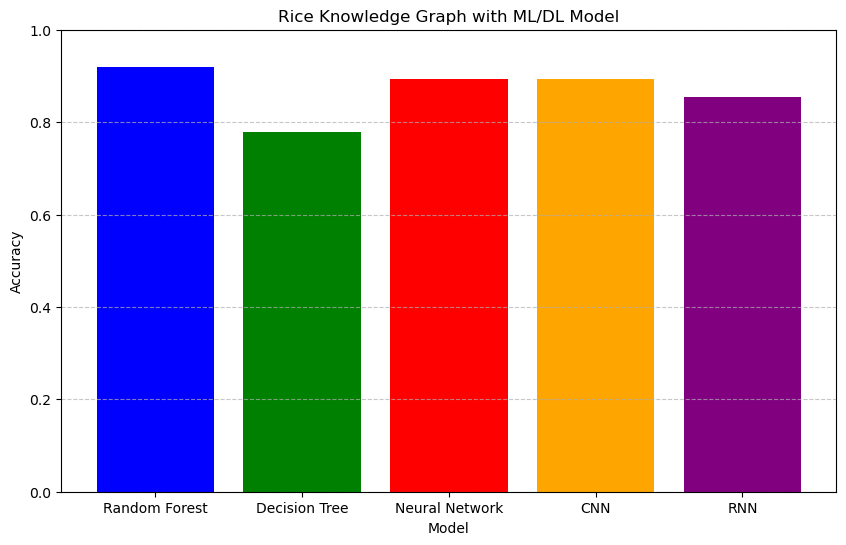

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the accuracy scores of four other models stored in variables

# Define the model names
model_names = ['Random Forest', 'Decision Tree', 'Neural Network', 'CNN', 'RNN']

# Define the accuracy scores
accuracy_scores = [np.mean(rf_accuracy), np.mean(dt_accuracy), nn_accuracy, cnn_accuracy, rnn_accuracy]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Rice Knowledge Graph with ML/DL Model')
plt.ylim(0, 1)  # Set the y-axis limits to ensure all bars are visible
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
